#  Discrete Non Linear Schödinger (NLS): preliminary experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-NLS">
             Initial value problem: NLS</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Float64-Computations">
             Float64 Computations</a></li>

<li><a href="#Float128-Computations">
             Float128 Computations</a></li> 

</ul>  

- This system has a nonseparable Hamiltonian that can be writen as

\begin{align*}
H(q,p)=\frac{1}{4} \sum_{i=1}^{N} (q_i+p_i)^2-\sum_{i=2}^{N} (p_{i-1}^2p_i^2+q_{i-1}^2q_i^2-q_{i-1}^2p_i^2-p_{i-1}^2q_i^2+4p_{i-1}q_{i-1}q_i)
\begin{align*}


- We have considered the next initial values of NLS with $N=5$

\begin{align*}
&(q_1,p_1)=(3,1) \\
&(q_i,p_i)=(0.01,0), \quad i \ne 1
\end{align*}

- Integration interval: $0 \le t \le 3$


- Reference: Explicit symplectic approximation of nonseparable
Hamiltonians: Algorithm and long time performance, Molei Tao, 2016, Phys.Rev.E 94, 043302

## Loading packages

In [1]:
using OrdinaryDiffEq, DiffEqDevTools
using IRKGaussLegendre
using Plots 
using Dates,LaTeXStrings
using JLD2, FileIO

┌ Info: Precompiling IRKGaussLegendre [58bc7355-f626-4c51-96f2-1f8a038f95a2]
└ @ Base loading.jl:1260


<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: NLS

In [5]:
include("../ODEProblems/NLS.jl")
include("../ODEProblems/InitialNLS.jl")

t0=0.0
t1=3.0

u064 =InitialNLS(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NLSODE!,u064,tspan64)

setprecision(BigFloat, 108);
u0128 =InitialNLS(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NLSODE!,u0128,tspan128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

(Array{Float64,1}, Tuple{Float64,Float64}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [5]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/NLS_test_sol.jld2" sol

@load "./Data/NLS_test_sol.jld2" sol
test_sol = TestSolution(sol);
sol.destats

u0256 =InitialNLS(BigFloat)
E0=NLSHam(u0256,[])
(Float32(sol.t[end]),Float32(NLSHam(sol.u[end],[])/E0.-1))

(3.0f0, 1.7947698f-33)

<a href="#top">Back to the top</a>

## Float64 Computations

### Vern9 

In [6]:
sol9 =solve(prob64,Vern9(),abstol=1e-12,reltol=1e-12);
sol9.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  5154
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          321
Number of rejected steps:                          1

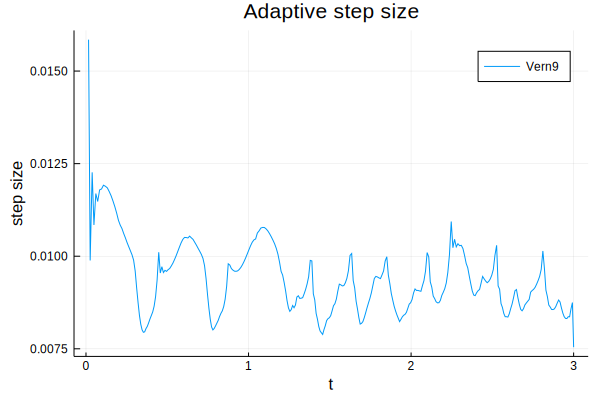

In [8]:
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
plot(sol9.t[2:end],steps9, xlabel="t", ylabel="step size",label="Vern9", title="Adaptive step size")

### IRKGL16 (adaptive time-stepping) 

In [9]:
sol1 = solve(prob64,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true,mixed_precision=false)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  10838
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          71
Number of rejected steps:                          20

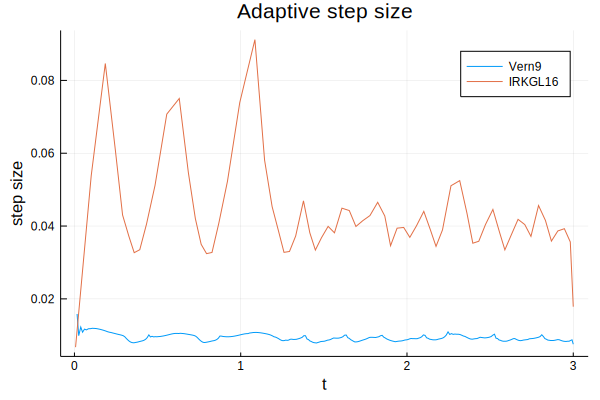

In [10]:
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
plot!(sol9.t[2:end],steps9, label="Vern9")
plot!(sol1.t[2:end],steps1, label="IRKGL16")

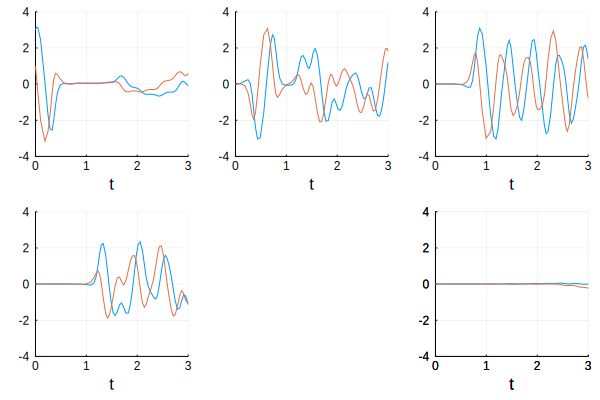

In [11]:
pl1=plot(sol1, vars=[1,6], label="") #label="(q1,p1)")
pl2=plot(sol1, vars=[2,7], label="") #label="(q2,p2)")
pl3=plot(sol1, vars=[3,8], label="") #label="(q3,p3)")
pl4=plot(sol1, vars=[4,9], label="") #label="(q4,p4)")
pl5=plot(sol1, vars=[5,10], label="") #label="(q5,p5)")

plot(pl1,pl2,pl3,pl4,pl5,pl5, layout=(2,3),ylims=(-4,4))

### IRKGL16 (fix time-stepping) 

In [12]:
sol2 = solve(prob64,IRKGL16(), dt=2e-2, adaptive=false, mixed_precision=false)
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  10602
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          150
Number of rejected steps:                          0

### Energy Error

In [13]:
setprecision(BigFloat, 256)
u0256 =InitialNLS(BigFloat)

E0=NLSHam(u0256,[])
ΔE1 = map(x->NLSHam(BigFloat.(x),[]), sol1.u)./E0.-1;
ΔE2 = map(x->NLSHam(BigFloat.(x),[]), sol2.u)./E0.-1;
ΔE9 = map(x->NLSHam(BigFloat.(x),[]), sol9.u)./E0.-1;
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE2))),Float32(maximum(abs.(ΔE9))))

(8.089705f-15, 3.9455353f-16, 5.3206612f-14)

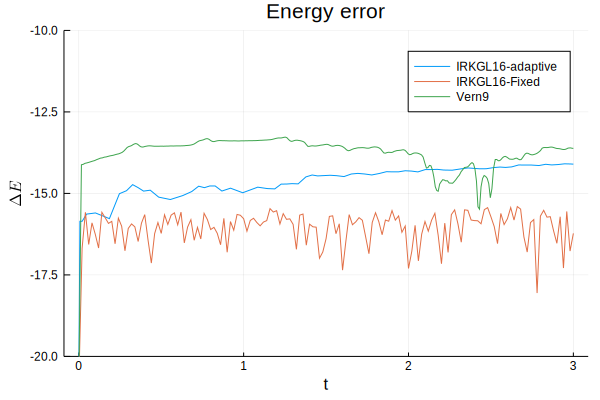

In [14]:
ylimit1=-20
ylimit2=-10
plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-adaptive",
     ylims=(ylimit1,ylimit2),)
plot!(sol2.t,log10.(abs.(ΔE2)), label="IRKGL16-Fixed",
     ylims=(ylimit1,ylimit2),)
plot!(sol9.t,log10.(abs.(ΔE9)), label="Vern9",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Float128 Computations

In [15]:
setprecision(BigFloat, 108);

### Vern9 

In [16]:
sol19 =solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20);
sol19.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  39154
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          2446
Number of rejected steps:                          1

### IRKGL16 

In [17]:
sol11 = solve(prob128,IRKGL16(),reltol=1e-20, abstol=1e-20, adaptive=true,mixed_precision=false)
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  32334
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          206
Number of rejected steps:                          24

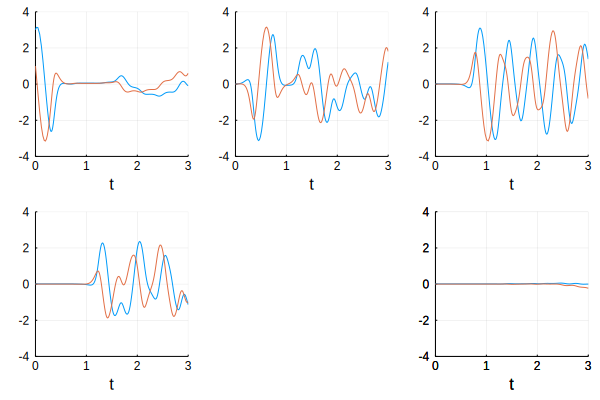

In [18]:
pl1=plot(sol11, vars=[1,6], label="") #label="(q1,p1)")
pl2=plot(sol11, vars=[2,7], label="") #label="(q2,p2)")
pl3=plot(sol11, vars=[3,8], label="") #label="(q3,p3)")
pl4=plot(sol11, vars=[4,9], label="") #label="(q4,p4)")
pl5=plot(sol11, vars=[5,10], label="") #label="(q5,p5)")

plot(pl1,pl2,pl3,pl4,pl5,pl5, layout=(2,3),ylims=(-4,4))

### IRKGL16 (Mixed-Precision)

In [19]:
sol12 = solve(prob128,IRKGL16(),reltol=1e-20, abstol=1e-20,adaptive=true,mixed_precision=true,low_prec_type=Float64)
sol12.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  9925
Number of function 2 evaluations:                  74880
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          206
Number of rejected steps:                          24

<a href="#top">Back to the top</a>

### Error in energy

In [20]:
setprecision(BigFloat, 256)
u0128 =InitialNLS(BigFloat)

E0=NLSHam(u0128,[])

ΔE11 = map(x->NLSHam(BigFloat.(x),[]), sol11.u)./E0.-1
ΔE12 = map(x->NLSHam(BigFloat.(x),[]), sol12.u)./E0.-1
ΔE19 = map(x->NLSHam(BigFloat.(x),[]), sol19.u)./E0.-1
(Float32(maximum(abs.(ΔE11))) ,Float32(maximum(abs.(ΔE12))),Float32(maximum(abs.(ΔE19))))

(3.1793723f-23, 3.1793723f-23, 5.281047f-22)

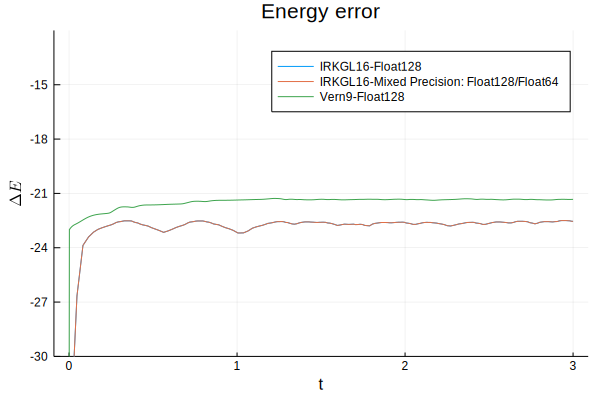

In [21]:
ylimit1=-30
ylimit2=-12

plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
plot!(sol11.t,log10.(abs.(ΔE11)), label="IRKGL16-Float128",
     ylims=(ylimit1,ylimit2),)
plot!(sol12.t,log10.(abs.(ΔE12)), label="IRKGL16-Mixed Precision: Float128/Float64",
     ylims=(ylimit1,ylimit2),)
plot!(sol19.t,log10.(abs.(ΔE19)), label="Vern9-Float128",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>